# Projet Data Camp

This project can be found at "./datacamp.pdf". The aim is to find a way to maximize the "cells" size eaten at specific location within a limited range of time.

## Preprocessing

In this section, we will import, open data and manage to explore and maybe reorganize them.

### Imports

In [1]:
# Datascience libraries
import pandas as pd
import numpy as np
import keras
from keras.layers import Dense
from keras.models import Sequential, load_model

# basic python libraries
import math
import time
from tqdm.notebook import tqdm as pb

# plot
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 16, 10

# local imports
from classes.Game import *
from classes.Strategy import *
from classes.Metrics import *

Using TensorFlow backend.


In [2]:
#Parser de fichiers
df = pd.read_csv("data.txt",header=None)
df.head()

,0,1,2,3
0,0,-11.03,-82.33,46
1,1,-4.93,-98.05,96
2,2,81.52,2.41,49
3,3,36.82,-42.62,71
4,4,-69.86,11.88,27


In [3]:
df.iloc[8,:]

0     8.00
1   -56.27
2    23.81
3    65.00
Name: 8, dtype: float64

## Reduce Graph and store it

In [52]:
def create_dist_matrix(M):
    dim = M.shape[0]
    dist_M = np.zeros((dim,dim))
    for i in pb(range(dim)):
        for j in range(dim):
            dist_M[i,j] = math.sqrt((M[i,1] - M[j,1])**2 + (M[i,2] - M[j,1])**2)
    return dist_M

def create_init_dist_array(M, pos):
    dim = M.shape[0]
    dist_arr = np.zeros((dim))
    for i in pb(range(dim)):
        dist_arr[i] = math.sqrt((pos[0] - M[i,1])**2 + (pos[1] - M[i,1])**2)
    return dist_arr

In [53]:
distances = create_dist_matrix(M)
distances.shape

(10000, 10000)

In [54]:
init_position = (0,0)
init_distances = create_init_dist_array(M, init_position)
init_distances.shape

(10000,)

## deep rl

In [55]:
class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions, discrete=False):
        super(ReplayBuffer, self).__init__()
        self.mem_size = max_size
        self.discrete = discrete
        self.state_memory = np.zeros((self.mem_size, input_shape))
        self.new_state_memory = np.zeros((self.mem_size, input_shape))
        dtype = np.int8 if self.discrete else np.float32
        self.action_memory = np.zeros((self.mem_size, n_actions), dtype=dtype)
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.mem_counter = 0
        
    def store_transition(self, state, action, reward, new_state, done):
        index = self.mem_counter % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = new_state
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1 - int(done)
        
        if self.discrete:
            actions = np.zeros(self.action_memory.shape[1])
            actions[action] = 1.0
            self.action_memory[index] = actions
        else:
            self.action_memory[index] = action
        self.mem_counter += 1
        
    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_counter, self.mem_size)
        batch = np.random.choice(max_mem, batch_size)
        
        states = self.state_memory[batch]
        new_states = self.new_state_memory[batch]
        rewards = self.reward_memory[batch]
        actions = self.action_memory[batch]
        terminal = self.terminal_memory[batch]
        
        return states, actions, rewards, new_states, terminal

In [56]:
class Agent(object):
    def __init__(self, alpha, gamma, n_actions, epsilon, batch_size, input_dims,
                fn, epsilon_decrease=0.0001, epsilon_min=0.0001, mem_size=1000000,
                fname="dqn_model"):
        super(Agent, self).__init__()
        self.action_space = [i for i in range(n_actions)]
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_decrease
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.model_file = fname
        
        self.memory = ReplayBuffer(mem_size, input_dims, n_actions, 
                                   discrete=True)
        self.q_eval = fn(alpha, n_actions, input_dims, 128, 128)
    
    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)
    
    def create_state(self, distances, rewards):
        return rewards/np.power(distances,3)
    
    def choose_action(self, state, time):
        rand = np.random.random()
        if rand < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            state_ = state[np.newaxis,:]
            actions = self.q_eval.predict(state_)
            action = np.argmax(actions)
        return action
    
    def learn(self):
        if self.memory.mem_counter < self.batch_size:
            return
        state, action, reward, new_state, done = self.memory.sample_buffer(self.batch_size)
        
        action_values = np.array(self.action_space, dtype=np.int8)
        action_indices = np.dot(action, action_values)
        
        q_eval = self.q_eval.predict(state)
        q_next = self.q_eval.predict(new_state)
        
        q_target = q_eval.copy()
        
        batch_index = np.arange(self.batch_size, dtype=np.int32)
        q_target[batch_index, action_indices] = reward + self.gamma*np.max(q_next, axis=1)*done
        
        
        _ = self.q_eval.fit(state, q_target, verbose=0)
        
        
    def decrease(self):
        self.epsilon = self.epsilon-self.epsilon_dec if self.epsilon > self.epsilon_min else self.epsilon_min
    def save_model(self):
        self.q_eval.save(self.model_file)
    def load_model(self):
        self.q_eval = load_model(self.model_file)

In [57]:
class Game(object):
    
    def __init__(self, time, distances, init_distances):
        super(Game, self).__init__()
        self._const_time = time
        self.distances = distances
        self.init_distances = init_distances
    
    # init a game and reset it
    def init_game(self, M, init_coord):
        self._Rewards = M[:,2]
        self._Ids = M[:, 0].astype(int)
        self.actual_position = -1
        self.ids = []
        self.rewards = []
        self.time = 0.
        return self.init_distances, self._Rewards

    # step in a game
    def step_env(self, action):
        # check if there is a correct action or not
        distance = self.distances[self.actual_position, action]
        if self.time + distance >= self._const_time:
            return self.distances[self.actual_position,:], self._Rewards, 1, True, "End of Game"
        else:
            # update rewards
            if self._Rewards[action] == 0.:
                previous_reward = -distance**3
            else:
                previous_reward = self._Rewards[action]/distance**3
            self.rewards.append(self._Rewards[action])
            self._Rewards[action] = 0.

            # update distance
            self.time += distance
            
            # move and keep track of action
            self.actual_position = action
            self.ids.append(self._Ids[action])

            # step into the environnement
            dist, rew, ids = self.find_n_nearest_neightbors(self.actual_position)
            return self.distances[self.actual_position,:], self._Rewards, previous_reward, False, "Step"
    
    # string representation of the object
    def __repr__(self):
        return "<Object : Game (DataCamp) <> time:{}>".format(self._const_time)
    def __str__(self):
        return self.__repr__()

In [58]:
def build_network(learning_rate, n_actions, input_dims, fc1_dims, fc2_dims):
    model = Sequential()
    model.add(Dense(fc1_dims, input_shape=(input_dims,), activation='relu'))
    model.add(Dense(fc2_dims, activation='relu'))
    model.add(Dense(n_actions, activation='softmax'))
    
    model.compile(optimizer="adam",loss="mse")
    
    return model

In [59]:
M = df.values
n = M.shape[0]
env = Game(10000., distances, init_distances)
agent = Agent(gamma=0.90, epsilon=1.0, alpha=0.001, input_dims=n, n_actions=n,
             fn=build_network,mem_size=10_000, batch_size=2000)
#agent.load_model()

In [60]:
_n_games = 100
scores = []
max_ = [0]
for epoch in range(1):
    agent.epsilon = 1.
    agent.epsilon_decrease= 1./_n_games,
    agent.epsilon_min= 1./_n_games
    for i in pb(range(_n_games)):
        done = False
        temp_distances, temp_rewards = env.init_game(np.copy(M), init_position)
        observation = agent.create_state(temp_distances, temp_rewards)
        while not done:
            action = agent.choose_action(observation, env._const_time - env.time)
            temp_distances, temp_rewards, reward, done, info = env.step_env(action)
            observation_ = agent.create_state(temp_distances, temp_rewards)
            agent.remember(observation, action, reward, observation_, done)
            observation = observation_
        agent.learn()
        agent.decrease()
        if max_[0] < sum(env.rewards):
            max_ = [sum(env.rewards), env.ids]
        scores.append(sum(env.rewards))
    agent.save_model() 

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [16]:
agent.save_model() 

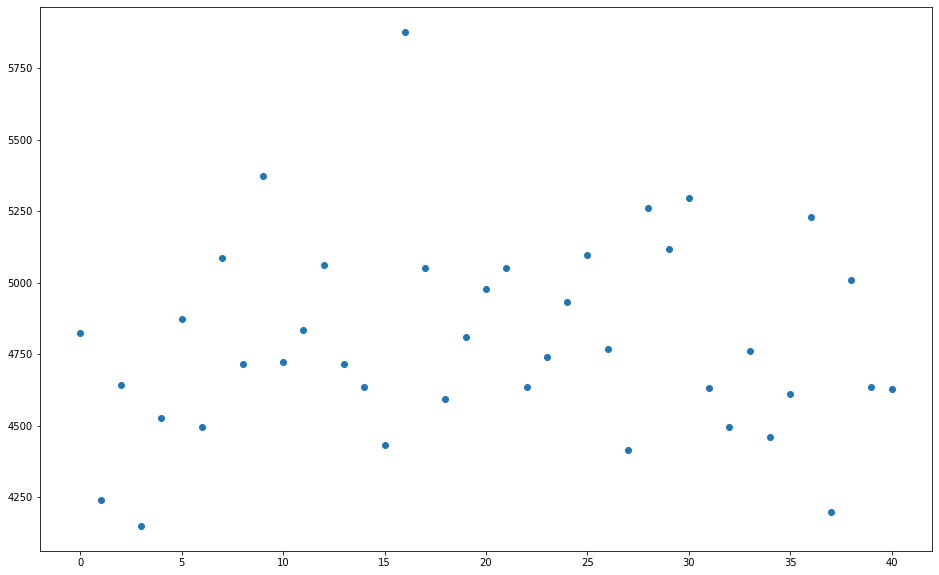

In [17]:
plt.scatter(np.arange(0, len(scores)),scores)

In [12]:
def check_result(M, ids):
    M_temp = np.copy(M)
    rewards = []
    dist = 10000.
    coordinate = (0.,0.)
    for i in ids:
        rewards.append(M_temp[i, 3])
        M_temp[i, 3] = 0.
        dist -= math.sqrt((coordinate[0] - M_temp[i, 1])**2 + (coordinate[1] - M_temp[i, 2])**2)
        coordinate = (M_temp[i, 1],M_temp[i, 2])
        
    print(dist, sum(rewards))

In [13]:
check_result(M,max_[1])

36.302929195682935 5452.0


In [27]:
np.zeros((10))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

array([ 87.23353942,  93.12      , 199.29623027, ..., 118.39940878,
        66.9264447 , 107.24787364])